#Path section

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fernando2rad/brain-tumor-mri-images-44c")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-mri-images-44c


#Part 1: Import Libraries

In [ ]:
# Install necessary libraries (if needed)
!pip install torchinfo
!pip install torch torchvision matplotlib seaborn scikit-learn pandas

# Import Libraries
import numpy as np
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torchinfo import summary
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import random
from tqdm.notebook import tqdm
from PIL import Image
import torchvision.models as models
import torchvision.transforms as transforms
import platform
import psutil


#Part 2: Dataset Loading

In [ ]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [ ]:
# Configuration
cpu_info = platform.processor()
ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

# Load dataset
data_dir = "/kaggle/input/brain-tumor-mri-images-44c"
file_paths = []
labels = []

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    for image_name in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, image_name))
        labels.append(class_name)

df = pd.DataFrame({"file_path": file_paths, "label": labels})
df = df.sample(frac=1).reset_index(drop=True)

# Train-Test-Validation Split
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.30, stratify=df['label'], random_state=42)
valid_dataframe, test_df = train_test_split(temp_dataframe, test_size=0.50, stratify=temp_dataframe['label'], random_state=42)

print("Training Data:", len(train_dataframe))
print("Validation Data:", len(valid_dataframe))
print("Test Data:", len(test_df))


CPU: x86_64
Total RAM (GB): 12.67
GPU: Tesla T4
Training Data: 3135
Validation Data: 672
Test Data: 672


#seed


In [ ]:
# Define device and batch size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_batch = 32 # Example batch size, adjust as needed
val_batch = 32 # Example batch size, adjust as needed

In [ ]:
# Create a label map from unique labels in the DataFrame
unique_labels = df['label'].unique()
label_map = {label: i for i, label in enumerate(unique_labels)}

print("Label Map:", label_map)

Label Map: {'_NORMAL T2': 0, 'Carcinoma T1': 1, 'Carcinoma T1C+': 2, 'Meningioma T2': 3, 'Germinoma T2': 4, 'Meningioma T1C+': 5, 'Schwannoma T1C+': 6, 'Ependimoma T2': 7, 'Neurocitoma T1C+': 8, 'Schwannoma T2': 9, 'Ganglioglioma T1C+': 10, 'Glioblastoma T1C+': 11, 'Papiloma T1C+': 12, 'Astrocitoma T1': 13, 'Germinoma T1C+': 14, 'Astrocitoma T2': 15, 'Schwannoma T1': 16, 'Meduloblastoma T1C+': 17, 'Glioblastoma T1': 18, 'Meningioma T1': 19, 'Tuberculoma T1C+': 20, 'Papiloma T1': 21, 'Glioblastoma T2': 22, 'Oligodendroglioma T1C+': 23, '_NORMAL T1': 24, 'Astrocitoma T1C+': 25, 'Papiloma T2': 26, 'Oligodendroglioma T2': 27, 'Ependimoma T1C+': 28, 'Neurocitoma T1': 29, 'Meduloblastoma T2': 30, 'Oligodendroglioma T1': 31, 'Carcinoma T2': 32, 'Granuloma T2': 33, 'Neurocitoma T2': 34, 'Granuloma T1': 35, 'Tuberculoma T2': 36, 'Germinoma T1': 37, 'Ganglioglioma T2': 38, 'Granuloma T1C+': 39, 'Ependimoma T1': 40, 'Ganglioglioma T1': 41, 'Meduloblastoma T1': 42, 'Tuberculoma T1': 43}


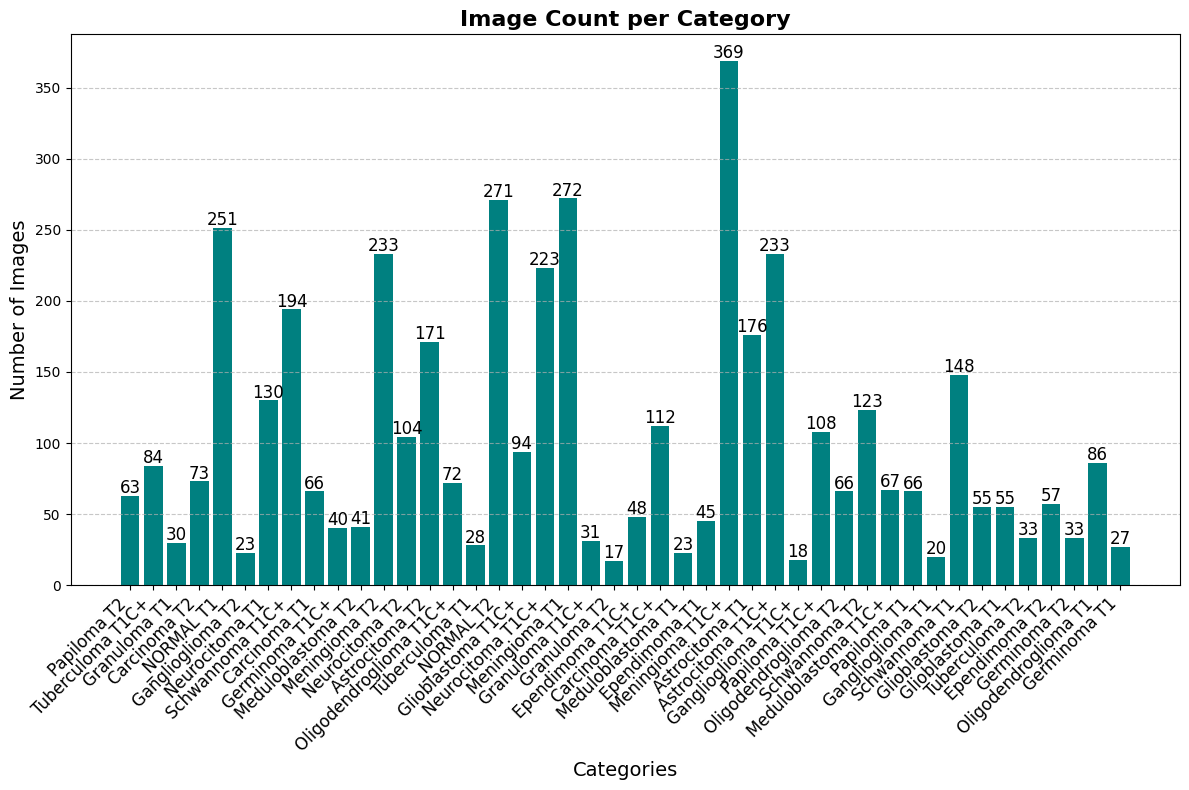

In [ ]:
import os
import matplotlib.pyplot as plt

# Define the path to your dataset
dataset_path = '/kaggle/input/brain-tumor-mri-images-44c'

# List the subdirectories (folders) in the dataset path (assuming each folder corresponds to a category)
categories = os.listdir(dataset_path)

# Count the number of images in each category (folder)
image_counts = [len(os.listdir(os.path.join(dataset_path, category))) for category in categories]

# Plotting the bar graph with improved aesthetics
plt.figure(figsize=(12, 8))
bars = plt.bar(categories, image_counts, color='teal')

# Adding titles and labels
plt.title('Image Count per Category', fontsize=16, fontweight='bold')
plt.xlabel('Categories', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)

# Customize x-axis labels to make them more readable
plt.xticks(rotation=45, ha='right', fontsize=12)

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels above each bar for clarity
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 2, int(yval), ha='center', fontsize=12, color='black')

# Show the plot with tight layout for optimal spacing
plt.tight_layout()
plt.show()


#Part 3: Custom CNN Model Definition
defined the custom CNN that combines ResNet, DenseNet, Inception-like modules, and EfficientNet backbone for feature extraction.

In [ ]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=44):
        super(CustomCNN, self).__init__()

        # Initial Conv Layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)  # Adjusted for RGB images
        self.maxpool = nn.MaxPool2d(2, 2)

        # ResNet-like Residual Block
        self.res_block1 = self._make_residual_block(64, 64)

        # DenseNet-like Block
        self.dense_block = self._make_dense_block(64, 128)

        # Inception-like Module
        self.inception_block = self._make_inception_block(128)

        # EfficientNet Backbone (using a pre-trained EfficientNetB0 as a feature extractor)
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        # Adjust the first layer of EfficientNet to accept 192 input channels
        self.efficientnet.features[0][0] = nn.Conv2d(192, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        self.efficientnet.classifier = nn.Identity()  # Remove the final classifier layer


        # Fully Connected Layer
        self.fc = nn.Linear(1280, num_classes)  # EfficientNetB0 outputs 1280 features before the classifier

    def _make_residual_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        return block

    def _make_dense_block(self, in_channels, growth_rate):
        block = nn.Sequential(
            nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1),
            nn.BatchNorm2d(growth_rate),
            nn.ReLU()
        )
        return block

    def _make_inception_block(self, in_channels):
        conv1x1 = nn.Conv2d(in_channels, 64, kernel_size=1)
        conv3x3 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        conv5x5 = nn.Conv2d(in_channels, 64, kernel_size=5, padding=2)
        return nn.ModuleList([conv1x1, conv3x3, conv5x5])

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)

        # Pass through ResNet-like block
        residual = self.res_block1(x)
        x = x + residual  # Add the residual connection

        # Pass through DenseNet-like block
        x = self.dense_block(x)

        # Pass through Inception-like block
        inception_outputs = [layer(x) for layer in self.inception_block]
        x = torch.cat(inception_outputs, dim=1)

        # Pass the output of Inception-like block to EfficientNet
        x = self.efficientnet(x)

        # Final classification layer
        x = self.fc(x)

        return x

# Instantiate and check the model summary
model = CustomCNN(num_classes=44).to(device)
summary(model, input_size=(train_batch, 3, 224, 224))  # Adjusted for RGB input

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                                       Output Shape              Param #
CustomCNN                                                    [32, 44]                  --
├─Conv2d: 1-1                                                [32, 64, 224, 224]        1,792
├─MaxPool2d: 1-2                                             [32, 64, 112, 112]        --
├─Sequential: 1-3                                            [32, 64, 112, 112]        --
│    └─Conv2d: 2-1                                           [32, 64, 112, 112]        36,928
│    └─BatchNorm2d: 2-2                                      [32, 64, 112, 112]        128
│    └─ReLU: 2-3                                             [32, 64, 112, 112]        --
│    └─Conv2d: 2-4                                           [32, 64, 112, 112]        36,928
│    └─BatchNorm2d: 2-5                                      [32, 64, 112, 112]        128
├─Sequential: 1-4                                            [32, 128, 112, 112]  

#Part 4: Data Preparation (Transformations & Dataset Class)
This section defines the data transformations and prepares the Dataset and DataLoader.


In [ ]:
# Dataset Class
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, label_map, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        self.label_map = label_map  # Use the generated label_map

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = Image.open(img_path)
        image = image.convert("RGB")  # Convert to RGB for compatibility

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)

# Data Transforms
def data_transfrom():
    normalize = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Add normalization for pre-trained models
    ])

    train_dataset = ImageDataset(train_dataframe, normalize, label_map, is_lb=True)
    valid_dataset = ImageDataset(valid_dataframe, normalize, label_map, is_lb=True)
    test_dataset = ImageDataset(test_df, normalize, label_map, is_lb=True)

    dataloader_train_dataset = DataLoader(train_dataset, batch_size=train_batch, shuffle=True)
    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size=val_batch, shuffle=False)
    dataloader_test_dataset = DataLoader(test_dataset, batch_size=val_batch, shuffle=False)

    return dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset

dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transfrom()

#Part 5: Training Loop

In [ ]:
# Training Setup
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Training Function
def train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, num_epochs=50, early_stop_patience=5, save_path_checkpoints="checkpoints"):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_val_acc = 0.0
    consecutive_no_improvement = 0

    # Create the checkpoints directory if it doesn't exist
    os.makedirs(save_path_checkpoints, exist_ok=True)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        progress_bar = tqdm(enumerate(dataloader_train_dataset), total=len(dataloader_train_dataset))
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
            progress_bar.set_postfix(loss=running_loss / total_train, acc=correct_train / total_train)

        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in dataloader_valid_dataset:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)  # Corrected line

        # Early stopping condition
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch + 1
            filepath = f"{save_path_checkpoints}/model.pt"
            checkpoint = {"epoch": epoch + 1, "model_weight": model.state_dict(), "optimizer_state": optimizer.state_dict()}
            torch.save(checkpoint, filepath)
            consecutive_no_improvement = 0  # Reset counter on improvement
        else:
            consecutive_no_improvement += 1


        # Early stopping criteria
        if consecutive_no_improvement >= early_stop_patience:
            print(f"Early stopping triggered after {epoch + 1} epochs due to no improvement in validation accuracy for {early_stop_patience} consecutive epochs.")
            break

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

# Start Training
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset)

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Early stopping triggered after 28 epochs due to no improvement in validation accuracy for 5 consecutive epochs.


#Part 6: Model Evaluation and Visualization

In [ ]:
# Evaluation Function
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total
    return loss, accuracy

# Best model evaluation
checkpoint = torch.load("checkpoints/model.pt")
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

test_loss, test_accuracy = evaluate_model(model, criterion, dataloader_test_dataset)
print(f"Test Accuracy: {test_accuracy:.3f}")


Test Accuracy: 0.930


#Part 7: Visualization

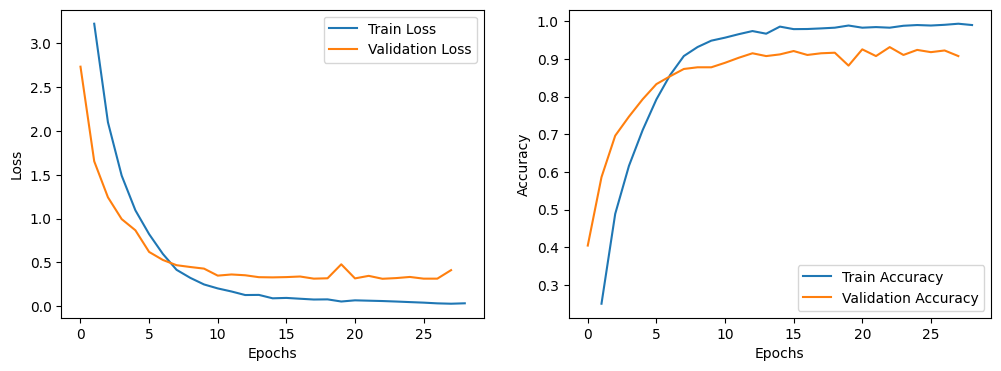

In [ ]:
# Plot Training History
history = pd.DataFrame({
    'Epoch': list(range(1, len(train_loss_history) + 1)),
    'Train Loss': train_loss_history,
    'Train Accuracy': train_acc_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_acc_history
})

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['Epoch'], history['Train Loss'], label='Train Loss')
plt.plot(history['Validation Loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['Epoch'], history['Train Accuracy'], label='Train Accuracy')
plt.plot(history['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


#Per class ACC


In [ ]:
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

    return class_accuracy

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloader_test_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Use the number of unique labels from the label_map
num_classes = len(label_map)
class_names = [str(i) for i in range(num_classes)]

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

class_acc = class_accuracy(model, dataloader_test_dataset, num_classes)
for i in range(num_classes):
    print(f"Class {i} Accuracy: {class_acc[i]:.3f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        41
           1       1.00      1.00      1.00        10
           2       1.00      0.94      0.97        17
           3       0.86      0.91      0.89        35
           4       0.80      0.80      0.80         5
           5       0.96      0.95      0.95        56
           6       0.90      0.90      0.90        29
           7       1.00      0.88      0.93         8
           8       1.00      0.94      0.97        34
           9       0.94      0.83      0.88        18
          10       1.00      1.00      1.00         3
          11       1.00      0.93      0.96        14
          12       0.93      0.88      0.90        16
          13       0.93      0.96      0.94        26
          14       0.86      1.00      0.92         6
          15       0.77      0.88      0.82        26
          16       0.85      1.00      0.92        22
    